In [1]:
!pip install torch torchvision


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/15], Train Loss: 1.5877, Train Acc: 41.95%, Val Loss: 1.2526, Val Acc: 55.60%
Epoch [2/15], Train Loss: 1.2458, Train Acc: 55.31%, Val Loss: 1.1129, Val Acc: 60.12%
Epoch [3/15], Train Loss: 1.1126, Train Acc: 60.30%, Val Loss: 1.0700, Val Acc: 61.45%
Epoch [4/15], Train Loss: 1.0296, Train Acc: 63.70%, Val Loss: 0.9259, Val Acc: 67.56%
Epoch [5/15], Train Loss: 0.9684, Train Acc: 66.00%, Val Loss: 0.8988, Val Acc: 68.21%
Epoch [6/15], Train Loss: 0.8918, Train Acc: 68.46%, Val Loss: 0.8247, Val Acc: 70.80%
Epoch [7/15], Train Loss: 0.8634, Train Acc: 69.81%, Val Loss: 0.8042, Val Acc: 71.33%
Epoch [8/15], Train Loss: 0.8432, Train Acc: 70.39%, Val Loss: 0.7931, Val Acc: 71.94%
Epoch [9/15], Train Loss: 0.8216, Train Acc: 71.18%, Val Loss: 0.7841, Val Acc: 72.12%
Epoch [10/15], Train Loss: 0.8041, Train Acc: 71.93%, Val Loss: 0.7569, Val Acc: 73.31%
Epoch [11/15], Train Loss: 0.7685,

<ipython-input-3-b06c2a0c2332>:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


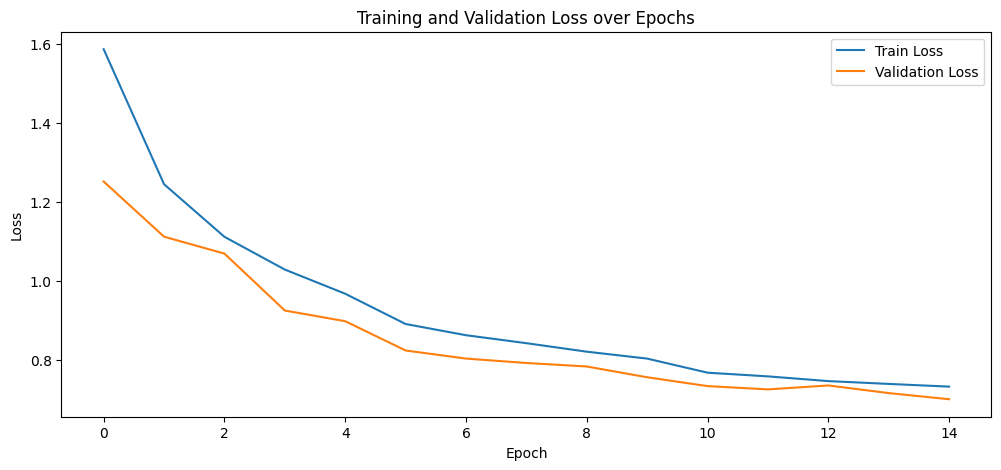

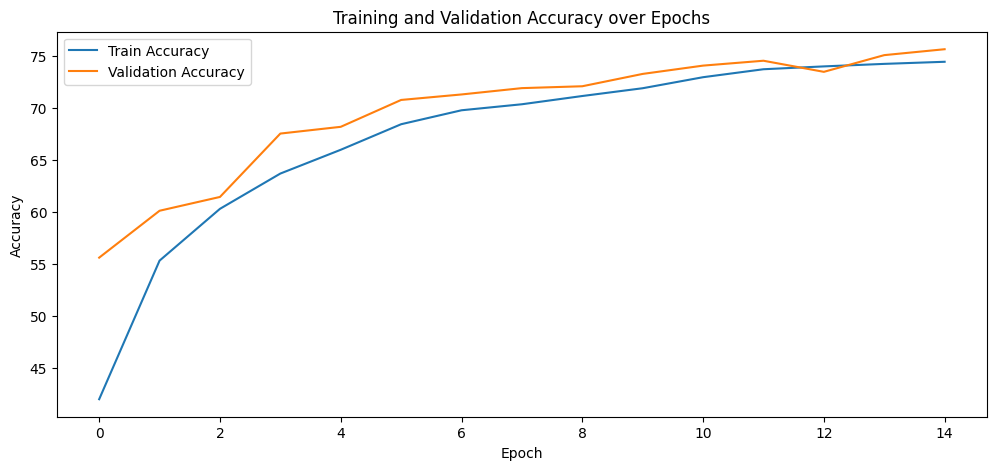

Final Test Accuracy: 74.73%


In [3]:
# Basic setup and checking for GPU
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Import Libraries
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Data Preparation with Data Augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Split training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create Data Loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Define an Improved CNN Model with Batch Normalization and Extra Layers
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.4)  # Adjust dropout rate

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)

model = BasicCNN().to(device)

# Training Setup with Adam Optimizer and Learning Rate Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
num_epochs = 15

train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

# Early Stopping Configuration
best_val_loss = float('inf')
patience, patience_counter = 5, 0  # Early stopping patience

# Training and Validation Loop
for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_loss_history.append(avg_train_loss)
    train_acc_history.append(train_accuracy)

    # Validation Phase
    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    # Adjust the learning rate
    scheduler.step()

# Load the best model before testing
model.load_state_dict(torch.load("best_model.pth"))

# Plot Training and Validation Losses
plt.figure(figsize=(12, 5))
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy over Epochs")
plt.legend()
plt.show()

# Testing Phase
model.eval()
correct_test, total_test = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f'Final Test Accuracy: {test_accuracy:.2f}%')
